# Bayesian Randomized Benchmarking  Demo

This is a bayesian pyMC3 implementation on top of frequentist interleaved RB from qiskit experiments

Based on this [WIP tutorial](https://github.com/gadial/qiskit-experiments/blob/rb_tutorial/docs/tutorials/rb_example.ipynb) 
on july 10 2021


In [2]:
import numpy as np
import copy
import qiskit_experiments as qe
import qiskit.circuit.library as circuits
rb = qe.randomized_benchmarking

# for retrieving gate calibration
from datetime import datetime
import qiskit.providers.aer.noise.device as dv

# import the bayesian packages
import pymc3 as pm
import arviz as az
import bayesian_fitter as bf

In [3]:
simulation = True # make your choice here
if simulation:
    from qiskit.providers.aer import AerSimulator
    from qiskit.test.mock import FakeParis
    backend = AerSimulator.from_backend(FakeParis())
else:
    from qiskit import IBMQ
    IBMQ.load_account()
    provider = IBMQ.get_provider(hub='ibm-q')
    backend = provider.get_backend('ibmq_lima') # type here hardware backend  

# Running 1-qubit RB

In [41]:
lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010
qubits = [0]

physical_qubits = [0]
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ
interleaved_gate =''

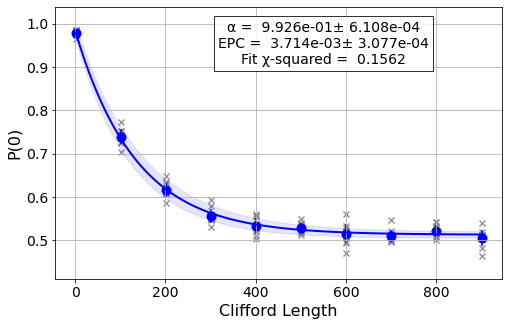

In [42]:
# Run an RB experiment on a single qubit
exp1 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)
expdata1 = exp1.run(backend)

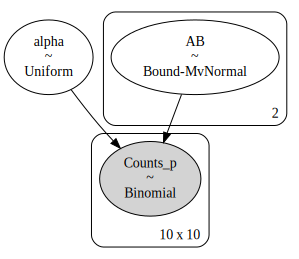

In [45]:
# retrieve from the frequentist model (fm) analysis
# some values,including priors, for the bayesian analysis
perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type = bf.retrieve_from_lsf(expdata1)
EPG_dic = expdata1._analysis_results[0]['EPG'][qubits[0]]
# get count data
Y = bf.get_GSP_counts(expdata1._data, len(lengths),range(num_samples))
shots = bf.guess_shots(Y)
#build model
original_model = bf.get_bayesian_model(model_type="pooled",Y=Y,shots=shots,m_gates=lengths,
                                           mu_AB=[popt_fm[0],popt_fm[2]],cov_AB=[perr_fm[0],perr_fm[2]],
                                           alpha_ref=popt_fm[1],
                                           alpha_lower=popt_fm[1]-6*perr_fm[1],
                                           alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]))
pm.model_to_graphviz(original_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 121 seconds.


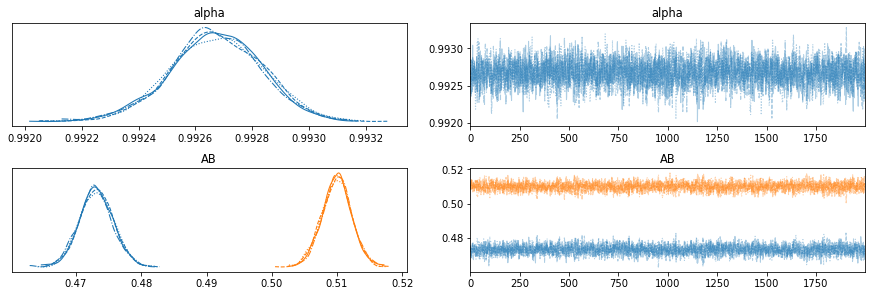

In [46]:
trace_o = bf.get_trace(original_model)

In [44]:
# backend's recorded EPG
print(rb.RBUtils.get_error_dict_from_backend(backend, qubits))

{((0,), 'id'): 0.0004432101747785104, ((0,), 'rz'): 0, ((0,), 'sx'): 0.0004432101747785104, ((0,), 'x'): 0.0004432101747785104}


           mean        sd    hdi_3%   hdi_97%
alpha  0.992672  0.000161  0.992357  0.992962
AB[0]  0.473104  0.002591  0.468478  0.478244
AB[1]  0.509946  0.002258  0.505750  0.514348 

Model:    Frequentist        Bayesian
_______________________________________
EPC         3.714e-03        3.664e-03 
± sigma    ± 3.077e-04      ± 8.050e-05 
EPG rz      0.000e+00        0.000e+00
EPG sx      4.404e-04        4.344e-04
EPG x       4.404e-04        4.344e-04


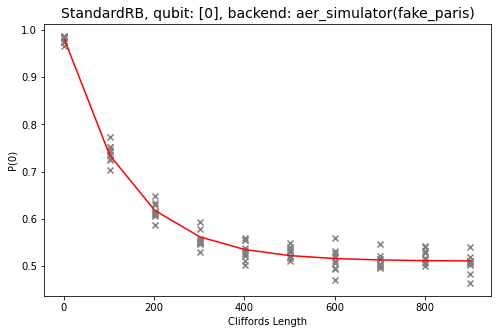

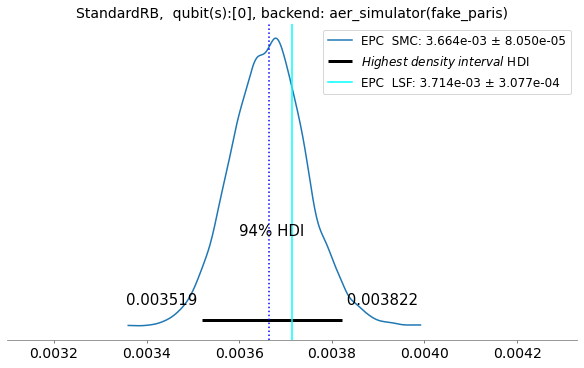

In [47]:
bf.RB_bayesian_results(original_model, trace_o, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic)

# Running 2-qubit RB

In [14]:
# describe RB experiment
interleaved_gate =''
physical_qubits = qubits = (1,4)
nQ = len(qubits)
scale = (2 ** nQ - 1) / 2 ** nQ # defined for the 2-qubit run
lengths = np.arange(1, 200, 30) 
lengths_1_qubit = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010

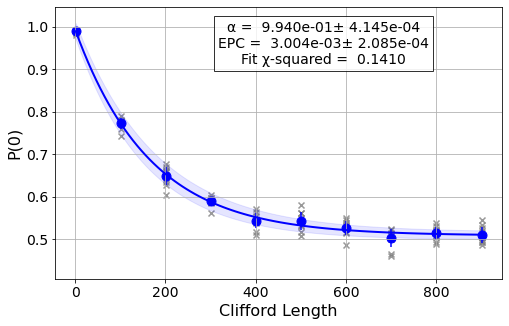

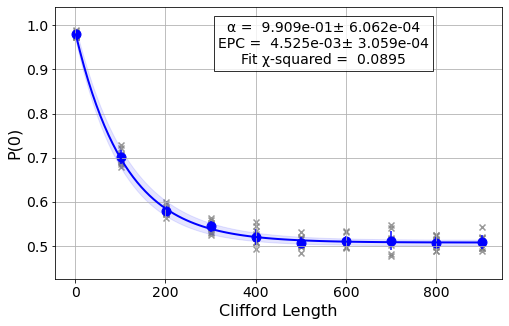

In [15]:
# Run a 1-qubit RB expriment on each qubit to determine the error-per-gate of 1-qubit gates
epg_data = {}
expdata_dic = {}
lengths_1_qubit = np.arange(1, 1000, 100)
for qubit in qubits:
    exp = rb.StandardRB([qubit], lengths_1_qubit, num_samples=num_samples, seed=seed)
    expdata_dic[qubit] = exp.run(backend)
    epg_data[qubit] = expdata_dic[qubit].analysis_result(0)['EPG'][qubit]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 124 seconds.


           mean        sd    hdi_3%   hdi_97%
alpha  0.993973  0.000127  0.993730  0.994201
AB[0]  0.484533  0.002677  0.479507  0.489491
AB[1]  0.507846  0.002545  0.502936  0.512378 



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 93 seconds.
The number of effective samples is smaller than 25% for some parameters.


           mean        sd    hdi_3%   hdi_97%
alpha  0.990993  0.000212  0.990584  0.991382
AB[0]  0.476004  0.002576  0.471086  0.480684
AB[1]  0.507820  0.002176  0.503683  0.511763 



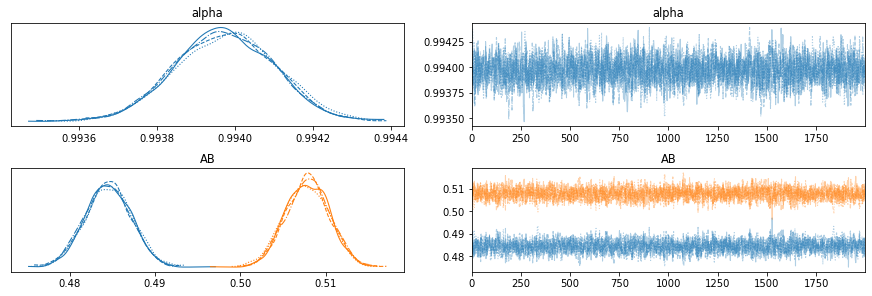

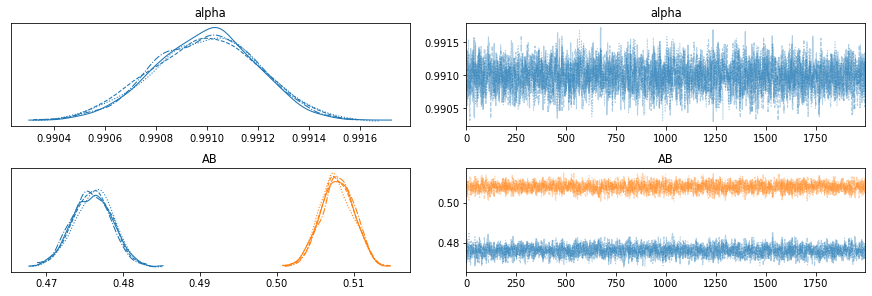

In [16]:
# Run a 1-qubit RB bayesian analysis on each qubit to determine the bayesian error-per-gate of 1-qubit gates
epg_data_bayes = {}

for qubit in qubits:
        # retrieve from the frequentist model (fm) analysis
        # some values,including priors, for the bayesian analysis
        perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type = bf.retrieve_from_lsf(expdata_dic[qubit])
        Y = bf.get_GSP_counts(expdata_dic[qubit]._data, len(lengths_1_qubit),range(num_samples))
        shots = bf.guess_shots(Y)
        #build and run model
        oneQ_model = bf.get_bayesian_model(model_type="pooled",Y=Y,shots=shots,m_gates=lengths_1_qubit,
                                           mu_AB=[popt_fm[0],popt_fm[2]],cov_AB=[perr_fm[0],perr_fm[2]],
                                           alpha_ref=popt_fm[1],
                                           alpha_lower=popt_fm[1]-6*perr_fm[1],
                                           alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]))
                                       
        trace_oneQ = bf.get_trace(oneQ_model)
        azoneQ_summary = bf.get_summary(oneQ_model, trace_oneQ, kind = 'stats')
        print(azoneQ_summary,'\n')
        epc_est_a = 0.5*(1 - azoneQ_summary['mean']['alpha']) # there is only one qubit, thus scale = 0.5
        epg_data_bayes[qubit] = {}
        for i, (gate,EPG) in enumerate(epg_data[qubit].items()):
            epg_data_bayes[qubit][gate] = EPG*epc_est_a/epc_est_fm

Backend's reported EPG: 0.012438847900902494
Experiment computed EPG: 0.013183098839010397


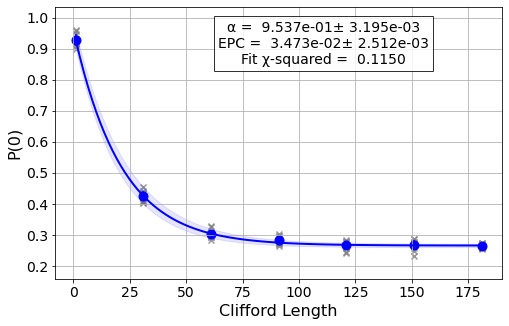

In [17]:
# Run a frequentist RB experiment on 2 qubits
exp2 = rb.StandardRB(qubits, lengths, num_samples=num_samples, seed=seed)

# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_data)

# Run the 2-qubit experiment
expdata2 = exp2.run(backend)

# Compare the computed EPG with the backend's recorded EPG:

expected_epg = rb.RBUtils.get_error_dict_from_backend(backend, qubits)[(qubits, 'cx')]
exp2_epg = expdata2.analysis_result(0)['EPG'][qubits]['cx']
print("Backend's reported EPG:", expected_epg)
print("Experiment computed EPG:", exp2_epg)

Backend's reported EPG: 0.012438847900902494
Experiment computed EPG: 0.01173898259297162


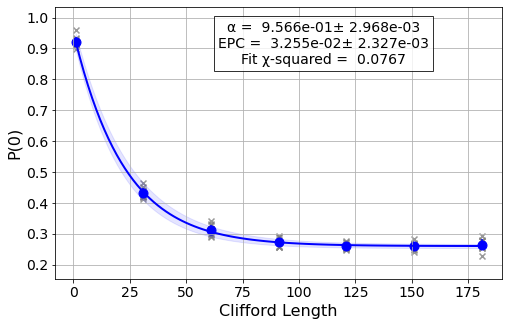

In [19]:
# Bayesian version
# Use the EPG data of the 1-qubit runs to ensure correct 2-qubit EPG computation
exp2.set_analysis_options(epg_1_qubit=epg_data_bayes)

# Run the 2-qubit experiment
expdata2b = exp2.run(backend)

# Compare the computed EPG with the backend's recorded EPG:

exp2_epg_b = expdata2b.analysis_result(0)['EPG'][qubits]['cx']
print("Backend's reported EPG:", expected_epg)
print("Experiment computed EPG:", exp2_epg_b)

### 2-qubit experiment bayesian analysis

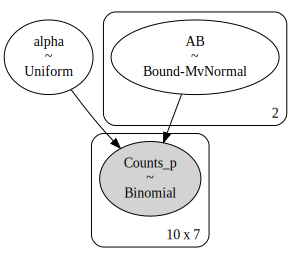

In [20]:
# retrieve from the frequentist model (fm) analysis
# some values,including priors, for the bayesian analysis
perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type = bf.retrieve_from_lsf(expdata2b)
EPG_dic = expdata2b._analysis_results[0]['EPG'][qubits]
# get count data
Y = bf.get_GSP_counts(expdata2b._data, len(lengths),range(num_samples))
shots = bf.guess_shots(Y)
#build model
S2QB_model = bf.get_bayesian_model(model_type="pooled",Y=Y,shots=shots,m_gates=lengths,
                                           mu_AB=[popt_fm[0],popt_fm[2]],cov_AB=[perr_fm[0],perr_fm[2]],
                                           alpha_ref=popt_fm[1],
                                           alpha_lower=popt_fm[1]-6*perr_fm[1],
                                           alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]))
                                           
pm.model_to_graphviz(S2QB_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 97 seconds.


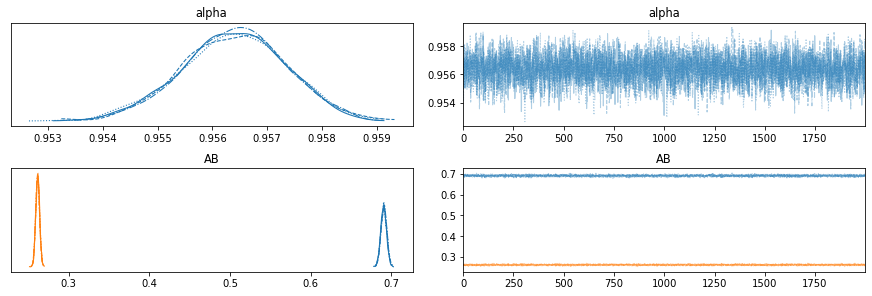

In [21]:
trace_s2 = bf.get_trace(S2QB_model)

           mean        sd    hdi_3%   hdi_97%
alpha  0.956390  0.000965  0.954464  0.958111
AB[0]  0.690810  0.003579  0.684187  0.697663
AB[1]  0.261578  0.002377  0.257286  0.266227 

Model:    Frequentist        Bayesian
_______________________________________
EPC         3.255e-02        3.271e-02 
± sigma    ± 2.327e-03      ± 7.238e-04 
EPG cx      1.174e-02        1.180e-02


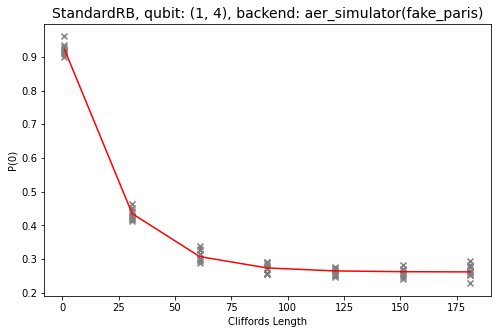

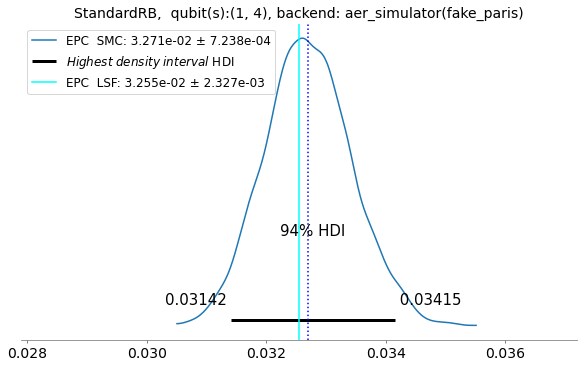

In [22]:
bf.RB_bayesian_results(S2QB_model, trace_s2, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                      
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       EPG_dic = EPG_dic)

# Running 1-qubit Interleaved RB

Note: from here "EPC" refers to the error on the interleaved gate 

In [52]:
# describe RB experiment
interleaved_gate = "x"
physical_qubits = [0]
qubits = [0]
interleaved_circuit = circuits.XGate()

lengths = np.arange(1, 1000, 100)
num_samples = 10
seed = 1010

### Least Squares Fit

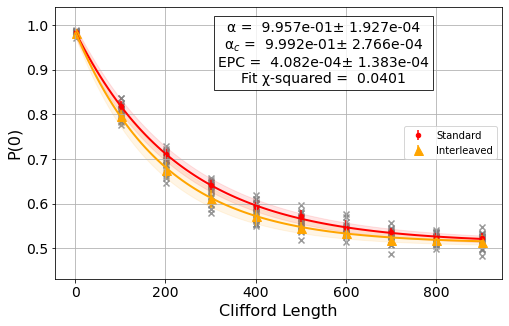

In [45]:
# Run an interleaved RB experiment

int_exp1 = rb.InterleavedRB(interleaved_circuit, qubits,
                            lengths, num_samples=num_samples, seed=seed)

int_expdata1 = int_exp1.run(backend)


###  Serial Monte Carlo

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) 

In [47]:
# retrieve from the frequentist model (fm) analysis
# some values,including priors, for the bayesian analysis
perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type = bf.retrieve_from_lsf(int_expdata1)

nQ = len(physical_qubits)
scale = (2 ** nQ - 1) / 2 ** nQ

Y1 = bf.get_GSP_counts(int_expdata1._data, len(lengths),
                    range(0,2*num_samples-1,2))

Y2 = bf.get_GSP_counts(int_expdata1._data, len(lengths),
                    range(1,2*num_samples,2))

Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))
shots = bf.guess_shots(Y)

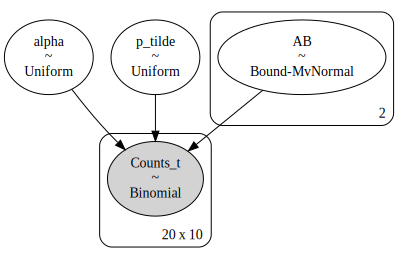

In [48]:
tilde1 =  bf.get_bayesian_model("tilde",Y=Y,shots=shots, m_gates=lengths,
                                         alpha_ref=popt_fm[1], p_testval= popt_fm[2],
                                         alpha_lower=popt_fm[1]-6*perr_fm[1],
                                         alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]),                            
                                         p_lower=popt_fm[2]-6*perr_fm[2],
                                         p_upper=min(1.-1.E-6,popt_fm[2]+6*perr_fm[2]),
                                         mu_AB=[popt_fm[0],popt_fm[3]],cov_AB=[perr_fm[0],perr_fm[3]],
                                         RvsI=RvsI,IvsR=IvsR)

pm.model_to_graphviz(tilde1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 146 seconds.


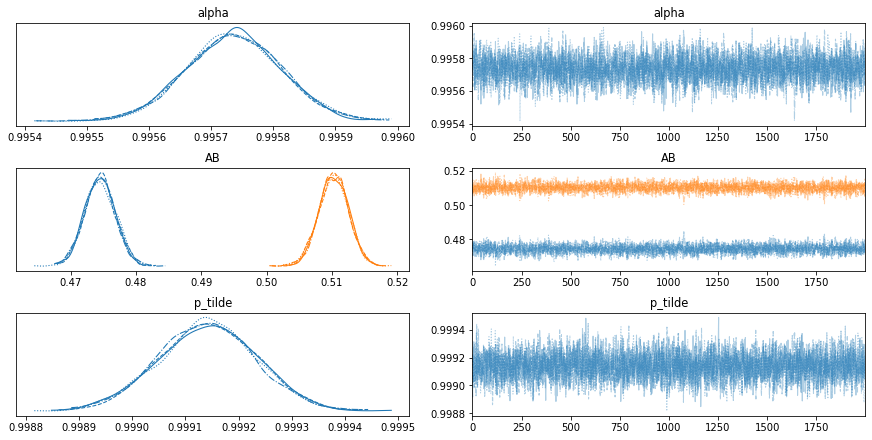

In [49]:
trace_t = bf.get_trace(tilde1)

In [ ]:
t = None # enter t in datetime format if necessary    
e_list = dv.gate_error_values(backend.properties()) # use properties(datetime=t) if t is defined
epc_calib = [item for item in e_list if item[0] == interleaved_gate and item[1] == physical_qubits][0][2]
print('EPC calibration: {0:.6f}'.format(epc_calib))

In [50]:
# example of interpolated EPC_cal for hardware experiments
# EPC0 + (t_exp - tO) * (EPC1 - EPC0) / (t1 - t0)
# code here:
# epc_calib = 2.307E-4 + (23.6-7)*(2.193E-4 - 2.307E-4)/24

             mean        sd    hdi_3%   hdi_97%
alpha    0.995737  0.000076  0.995596  0.995882
AB[0]    0.474471  0.002342  0.469940  0.478703
AB[1]    0.510266  0.002253  0.505915  0.514341
p_tilde  0.999142  0.000091  0.998975  0.999318 

Model:    Frequentist         Bayesian        Calibration
__________________________________________________________
EPC         4.082e-04        4.290e-04         4.432e-04
± sigma    ± 1.383e-04      ± 4.550e-05 


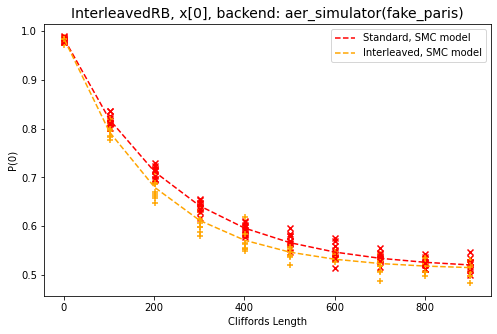

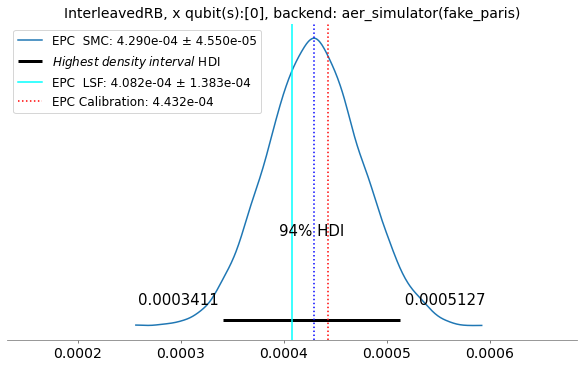

In [51]:
bf.RB_bayesian_results(tilde1, trace_t, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                       
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       epc_calib = epc_calib, Y1 = Y1, Y2 = Y2)

# Running 2-qubit Interleaved RB
Note: "EPC" here refers to the error on the interleaved gate

In [21]:
# describe RB experiment
interleaved_gate = "cx"
physical_qubits = [1,4]
qubits = [1,4]
interleaved_circuit = circuits.CXGate()
lengths = np.arange(1, 200, 30) 
num_samples = 10
seed = 1010

### Least Squares Fit

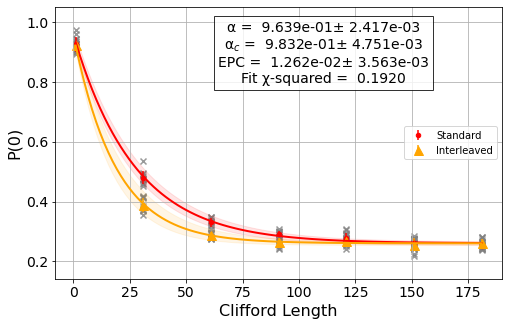

In [23]:
# Run an Interleaved RB experiment
interleaved_circuit = circuits.CXGate()
int_exp2 = rb.InterleavedRB(interleaved_circuit, physical_qubits,
                            lengths, num_samples=num_samples, seed=seed)
int_expdata2 = int_exp2.run(backend)

###  Serial Monte Carlo

model: [equation 6 in this paper](https://arxiv.org/abs/1404.5275) 

In [25]:
# retrieve from the frequentist model (fm) analysis
# some values,including priors, for the bayesian analysis
perr_fm, popt_fm, epc_est_fm, epc_est_fm_err, experiment_type = bf.retrieve_from_lsf(int_expdata2)

nQ = len(physical_qubits)
scale = (2 ** nQ - 1) / 2 ** nQ

Y1 = bf.get_GSP_counts(int_expdata2._data, len(lengths),
                    range(0,2*num_samples-1,2))

Y2 = bf.get_GSP_counts(int_expdata2._data, len(lengths),
                    range(1,2*num_samples,2))

Y = np.vstack((Y1,Y2))
RvsI = np.vstack((np.ones_like(Y1),np.zeros_like(Y2)))
IvsR = np.vstack((np.zeros_like(Y1),np.ones_like(Y2)))
shots = bf.guess_shots(Y1)

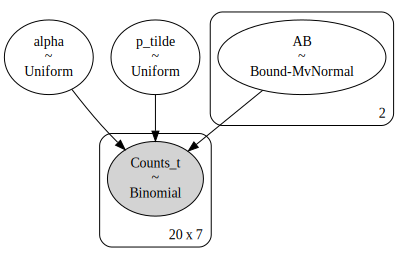

In [26]:
tilde2 =  bf.get_bayesian_model("tilde",Y=Y,shots=shots, m_gates=lengths,
                                         alpha_ref=popt_fm[1], p_testval= popt_fm[2],
                                         alpha_lower=popt_fm[1]-6*perr_fm[1],
                                         alpha_upper=min(1.-1.E-6,popt_fm[1]+6*perr_fm[1]),                            
                                         p_lower=popt_fm[2]-6*perr_fm[2],
                                         p_upper=min(1.-1.E-6,popt_fm[2]+6*perr_fm[2]),
                                         mu_AB=[popt_fm[0],popt_fm[3]],cov_AB=[perr_fm[0],perr_fm[3]],
                                         RvsI=RvsI,IvsR=IvsR)
pm.model_to_graphviz(tilde2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_tilde, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 164 seconds.


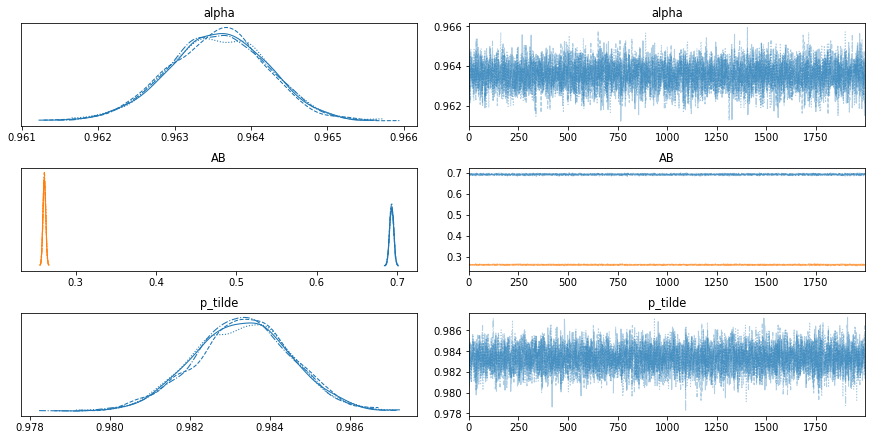

In [27]:
trace_t2 = bf.get_trace(tilde2)

In [41]:
t = None # enter t in datetime format if necessary    
e_list = dv.gate_error_values(backend.properties()) # use properties(datetime=t) if t is defined
epc_calib = [item for item in e_list if item[0] == interleaved_gate and item[1] == physical_qubits][0][2]
print('EPC calibration: {0:.6f}'.format(epc_calib)) 

EPC calibration: 0.012439


             mean        sd    hdi_3%   hdi_97%
alpha    0.963565  0.000649  0.962354  0.964781
AB[0]    0.693259  0.002534  0.688264  0.697794
AB[1]    0.261267  0.001692  0.258164  0.264519
p_tilde  0.983313  0.001200  0.981047  0.985538 

Model:    Frequentist         Bayesian        Calibration
__________________________________________________________
EPC         1.262e-02        1.252e-02         1.244e-02
± sigma    ± 3.563e-03      ± 9.000e-04 


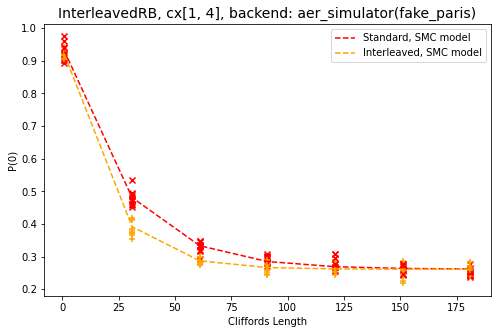

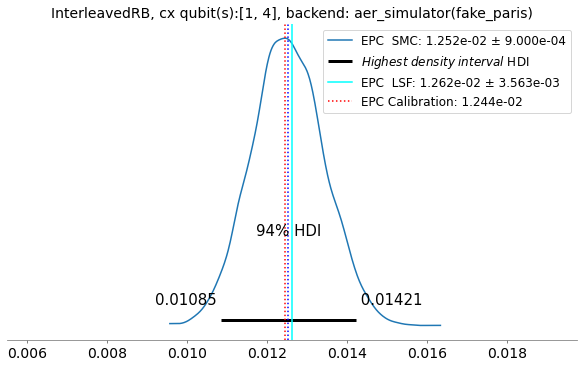

In [43]:
bf.RB_bayesian_results(tilde2, trace_t2, lengths,
                       epc_est_fm, epc_est_fm_err, experiment_type, scale,                      
                       num_samples, Y, shots, physical_qubits, interleaved_gate, backend,
                       epc_calib = epc_calib, Y1 = Y1, Y2 = Y2)